# 🛠 Exercises

## 1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it, and make a prediction on it using a trained model.

In [1]:
# import libraries
import os
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf

In [2]:
# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip data
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-11-28 13:26:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.96.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.4MB/s    in 4.6s    

2023-11-28 13:27:04 (35.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# set directories
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [4]:
# create data loaders from the dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224, 224))
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224, 224))

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
# create a simple model from scratch
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(len(train_data.class_names), activation = 'softmax')
])

# compile a model
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# train a model
history_1 = model_1.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(len(test_data) * 0.5))

Epoch 1/10
24/24 [==============================] - 18s 198ms/step - loss: 1118.3171 - accuracy: 0.1093 - val_loss: 2.4496 - val_accuracy: 0.1042
Epoch 2/10
24/24 [==============================] - 5s 180ms/step - loss: 1.9335 - accuracy: 0.3813 - val_loss: 2.6450 - val_accuracy: 0.1186
Epoch 3/10
24/24 [==============================] - 6s 206ms/step - loss: 0.9337 - accuracy: 0.7467 - val_loss: 4.2540 - val_accuracy: 0.1290
Epoch 4/10
24/24 [==============================] - 5s 181ms/step - loss: 0.3443 - accuracy: 0.9173 - val_loss: 5.6737 - val_accuracy: 0.1242
Epoch 5/10
24/24 [==============================] - 7s 290ms/step - loss: 0.2200 - accuracy: 0.9613 - val_loss: 8.5078 - val_accuracy: 0.1242
Epoch 6/10
24/24 [==============================] - 5s 180ms/step - loss: 0.1479 - accuracy: 0.9720 - val_loss: 8.8085 - val_accuracy: 0.1354
Epoch 7/10
24/24 [==============================] - 5s 179ms/step - loss: 0.1497 - accuracy: 0.9800 - val_loss: 6.8953 - val_accuracy: 0.1386
Ep

In [6]:
model_1.evaluate(test_data)

79/79 [==============================] - 4s 49ms/step - loss: 10.2927 - accuracy: 0.1304


[10.29272174835205, 0.13040000200271606]

In [34]:
# function to visualize a random image from the dataset
def plot_images(train_dir, test_dir, train_data, model):
    # set an image path
    class_list = train_data.class_names
    target_class = random.choice(class_list)
    target_dir = random.choice([train_dir, test_dir])
    chosen_path = target_dir + target_class
    random_image = random.choice(os.listdir(chosen_path))
    random_image_path = os.path.join(chosen_path, random_image)

    # prediction
    random_data = Image.open(random_image_path)
    random_data = np.asarray(random_data.resize((224, 224)))
    pred_prob = model.predict(np.expand_dims(random_data, axis = 0)) # add a batch_size
    pred_class = class_list[pred_prob.argmax(axis = 1)[0]]

    # image
    img = mpimg.imread(random_image_path)
    plt.imshow(img)
    plt.title(f"Image class: {target_class} | Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 0s 20ms/step


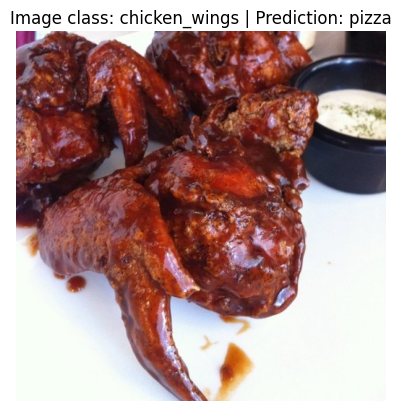

In [35]:
plot_images(train_dir, test_dir, train_data, model_1)

## 2. Use feature extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to the file.

In [38]:
# get the pre-trained base model
effnetv2_feature_extraction = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# change trainable attribute to False
effnetv2_feature_extraction.trainable = False

24274472/24274472 [==============================] - 1s 0us/step


In [39]:
# create ModelCheckpoint callback
# set checkpoint path
checkpoint_path = "model_checkpoint_weights/checkpoint.ckpt"

# create a callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

In [43]:
# create data_augmentation seq layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
])

# create a model
inputs = tf.keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
x = effnetv2_feature_extraction(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model_2 = tf.keras.Model(inputs = inputs, outputs = outputs)

# compile a model
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# train a model
model_2.fit(train_data,
            epochs=10,
            validation_data=test_data,
            validation_steps=int(len(test_data) * 0.5),
            callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.0145 - accuracy: 0.3373
Epoch 1: val_loss improved from inf to 1.53384, saving model to model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 32s 903ms/step - loss: 2.0145 - accuracy: 0.3373 - val_loss: 1.5338 - val_accuracy: 0.6226
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.6547
Epoch 2: val_loss improved from 1.53384 to 1.06566, saving model to model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 704ms/step - loss: 1.4035 - accuracy: 0.6547 - val_loss: 1.0657 - val_accuracy: 0.7676
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.7133
Epoch 3: val_loss improved from 1.06566 to 0.85769, saving model to model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 682ms/step - loss: 1.1124 - accuracy: 0.7133 - val_loss: 0.8577 - val_accuracy: 0.7821

## 3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

## 4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

# 📖 Extra-curriculum

- Read the [documentation on data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) in TensorFlow.
- Read the [ULMFit paper](https://arxiv.org/abs/1801.06146) (technical) for an introduction to the concept of freezing and unfreezing different layers.
- Read up on learning rate scheduling (there's a [TensorFlow callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) for this), how could this influence our model training?
    - If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.